<p><img alt="Colaboratory logo" height="45px" src="/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

**Laboratorio N°5**

---


######**Redes Neuronales Transformer - Keras**

Reconocimiento de emocion y genero por audio de voz de personas, utilizando dataset

Integrantes:

- [G101] Felipe Antonio Perez

- [G102] Karina Grissel Sánchez

- [G103] Ismael Rubén Jara

- [G104] Juan Pablo González

# Objetivo

Construir un modelo de IA que detecte el genero y sentimiento que presenta una persona en un clip de audio usando DL.

# Alcances

- Considerar los Dataset: RAVDESS, CREMA-D, TESS y SAVEE.

- Grabar un conjunto de clips de audios e incorporar a la Base de Datos una vez construido y validado el modelo.

- Realizar predicciones en base a un clip de audio al ingresar al modelo via on-line desde un archivo (wav/mp3) y, alternativamente, desde un microfono.

- El modelo debe ser un modelo propio (No se consideraran modelos pre-entrenados).

- Antes del proceso de prediccion final, el modelo propio debe considerar un proceso de optimizacion.

# 0- Validaciones previas

## Actualizar paquetes de ambiente virtual

Los comandos !apt-get update y !apt-get install -y libsndfile1 son comandos de terminal utilizados en entornos basados en Debian o Ubuntu para actualizar la lista de paquetes disponibles y luego instalar el paquete libsndfile1, respectivamente.

El comando apt-get update actualiza la lista de paquetes disponibles en los repositorios configurados en el sistema. Esto asegura que obtengas la información más reciente sobre los paquetes y las versiones disponibles.

El comando apt-get install -y libsndfile1 instala el paquete libsndfile1 sin solicitar confirmación durante la instalación (-y). Este paquete es una biblioteca de código abierto que se utiliza para leer y escribir archivos de audio en varios formatos.

In [1]:
!apt-get update
!apt-get install -y libsndfile1

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [1,084 kB]
Get:7 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:10 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Get:12 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1,372 kB]
Hit:13 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal 

## Montar directorio Google Drive

El código importa el módulo drive de la biblioteca google.colab y luego utiliza la función mount() para montar Google Drive en el entorno de Colab.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Verificar existencia de GPU con capcidad de computo


El código importa la función list_local_devices() del módulo device_lib de TensorFlow. Esta función devuelve una lista de los dispositivos locales disponibles en el sistema, incluyendo las GPUs.

In [3]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return local_device_protos
print(get_available_gpus())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6714093589886998422
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15208677376
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15068324342717876544
physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"
xla_global_id: 416903419
]


# 1- Instalacion de librerias

## Import de librerias a utilizar

Se importan varias bibliotecas necesarias para el procesamiento de audio y la construcción de un modelo de red neuronal utilizando Keras, las cuales son:

- pandas (import pandas as pd): Se utiliza para manipular y analizar datos en forma de estructuras de datos tabulares, como DataFrames.
- numpy (import numpy as np): Proporciona funciones para trabajar con matrices y operaciones matemáticas eficientes.
- os y sys: Estas bibliotecas proporcionan funciones para interactuar con el sistema operativo, como manipulación de archivos y rutas.
- librosa: Es una biblioteca de Python para análisis de audio. Proporciona funciones para cargar archivos de audio, extraer características y visualizar señales de audio.
- seaborn y matplotlib.pyplot: Estas bibliotecas se utilizan para realizar visualizaciones gráficas de datos.
- keras: Un framework de aprendizaje profundo de alto nivel. Se utiliza para construir y entrenar modelos de redes neuronales.
- StandardScaler y OneHotEncoder de sklearn.preprocessing: Estas clases se utilizan para realizar preprocesamiento de datos, como estandarización y codificación one-hot.
- confusion_matrix y classification_report de sklearn.metrics: Estas funciones se utilizan para evaluar el rendimiento del modelo mediante la creación de una matriz de confusión y un informe de clasificación.
- train_test_split de sklearn.model_selection: Se utiliza para dividir los datos en conjuntos de entrenamiento y prueba.
- Audio de IPython.display: Esta clase se utiliza para mostrar y reproducir archivos de audio en Jupyter Notebook.
- ReduceLROnPlateau, Sequential, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization y ModelCheckpoint de keras.callbacks y keras.layers: Estas clases y capas son utilizadas para construir y configurar el modelo de red neuronal.

Además, se establecen algunas configuraciones para ignorar las advertencias y mensajes de deprecación.

In [4]:
import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from IPython.display import Audio
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 2- Carga de dataset

Se proporcionan rutas de directorio para los conjuntos de datos de audio utilizados en el proyecto. Aquí hay una explicación de las variables y las rutas a los conjuntos de datos:

- Ravdess: La variable Ravdess contiene la ruta al directorio que almacena el conjunto de datos RAVDESS. El directorio audio_speech_actors_01-24 dentro de Ravdess contiene archivos de audio del dataset etiquetados para el reconocimiento de emociones. Estos contienen 140 archivos, ue 60 son de ensayos por actor x 24 actores. Los actores profesionales de voz (12 mujeres y 12 hombres) vocalizando dos lexicamente coincidentes con un acento americano neutral. Las emociones del habla incluyen expresiones de calma, felicidad, tristeza, enojo, miedo, sorpresa y disgusto. Cada expresion se produce en dos niveles de intensidad emocional (Normal y fuerte), con una expresion neutra adicional.

- Crema: La variable Crema contiene la ruta al directorio que almacena el conjunto de datos CREMA-D. El directorio AudioWAV dentro de Crema que contiene archivos de audio utilizados para el reconocimiento de emociones. Este es un conjunto de datos de 7442 clips originales con 91 actoires de voz. Estos clipos fueron de 48 actores masculinos y 43 femeninos entre las edades de 20 y 74 años proveniente de varias etnias (Afroamericanos, asiaticos, caucasicos, hispanos y no especificados). Los actores hablaron de una seccion de 12 frases. Las oraciones se presentaron usando una de seis emociones (Ira, disgusto, miedo, feliz, neutral y triste) y cuatro nvieles de emocion diferente (Bajo, medio, alto y sin especificar).

- Tess: La variable Tess contiene la ruta al directorio que almacena el conjunto de datos TESS. El directorio TESS Toronto emotional speech set data dentro de Tess probablemente contiene archivos de audio etiquetados para el reconocimiento de emociones. En esta participaron 2 actrices de voz (De 26 y 64 años de edad) y pronunciaron un conjunto de 200 palabnbras objetivo en la frase portadora "Diga la palabra __" y realizaron grabaciones del conjunto que representan cada una de las siete emociones (Ira, asco, miedo, felicidad, sorpresa agradable, tristeza y neutral). Hay 2800 archivos de audio en total.

- Savee: La variable Savee contiene la ruta al directorio que almacena el conjunto de datos SAVEE. El directorio ALL dentro de Savee contiene archivos de audio utilizados para el reconocimiento de emociones. En este set de datos participaron cuatro hablantes nativos de ingles, que son estudiantes de posgrado e investigadores de la Universidad de Surrey con edades comprendidas de los 27 a los 31 años. La emociones descritas dentro del set estan descritas psicologicamente como Ira, asco, miedo, felicidad, tristeza y sorpresa. Tambien agrega una categoria neutral para proporcionar grabaciones de 7 categorias de emociones. El material de texto consistio en 15 oraciones por emocion: 3 emociones comunes, 2 especificas de la emocion y 10 oraciones genericas que era cada emocion y foneticamente balanceada. Las 3 oraciones comunes y 2 x 16 = 12 oraciones especificas de emociones se registraron como neutrales para dar 30 oraciones neutrales. Esto dio como resultado un total de 120 declaraciones por hablante.

Estas rutas indican los directorios donde se encuentran los archivos de audio para cada conjunto de datos respectivo.

In [5]:
# Paths for data.
Ravdess = "/content/drive/MyDrive/datasets/Speech/RAVDESS/audio_speech_actors_01-24/"
Crema = "/content/drive/MyDrive/datasets/Speech/CREMA-D/AudioWAV/"
Tess = "/content/drive/MyDrive/datasets/Speech/TESS/TESS Toronto emotional speech set data/"
Savee = "/content/drive/MyDrive/datasets/Speech/SAVEE/ALL/"


# 3- Exploracion de datos

**RAVDESS**

Esta parte del código procesa los archivos de audio en el directorio Ravdess, extrae las emociones y las rutas de los archivos, y crea un DataFrame (Ravdess_df) que contiene información sobre las emociones asociadas a cada archivo y las rutas de los archivos.

In [10]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_gender = []
file_path = []
for dir in ravdess_directory_list:
    # Extraemos los archivos para cada actor.
    actor = os.listdir(Ravdess + "/" + dir)
    for file in actor:
        parts = file.split('.')[0].split('-')
        if len(parts) >= 3:
            # La tercera parte de cada archivo representa la emoción asociada.
            file_emotion.append(int(parts[2]))
            if int(parts[6]) % 2 == 0:
                file_gender.append(0)
            else:
                file_gender.append(1)
            file_path.append(Ravdess + "/" + dir + '/' + file)

# Dataframe para las emociones  y genero de los archivos.
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
gender_df = pd.DataFrame(file_gender, columns=['Gender'])

# Dataframe para las rutas de los archivos.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([gender_df,emotion_df, path_df], axis=1)

# Cambiar los enteros por las emociones reales.
Ravdess_df.Emotions.replace({1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad', 5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'}, inplace=True)
Ravdess_df.Gender.replace({0: 'female', 1: 'male'}, inplace=True)
Ravdess_df.head()



,Gender,Emotions,Path
0,female,calm,/content/drive/MyDrive/datasets/Speech/RAVDESS...
1,female,calm,/content/drive/MyDrive/datasets/Speech/RAVDESS...
2,female,fear,/content/drive/MyDrive/datasets/Speech/RAVDESS...
3,female,happy,/content/drive/MyDrive/datasets/Speech/RAVDESS...
4,female,sad,/content/drive/MyDrive/datasets/Speech/RAVDESS...


**CREMA**

Esta parte del código procesa los archivos de audio en el directorio Crema, extrae las emociones y las rutas de los archivos, y crea un DataFrame (Crema_df) que contiene información sobre las emociones asociadas a cada archivo y las rutas de los archivos. Las emociones se mapean según las abreviaturas presentes en los nombres de los archivos (por ejemplo, 'SAD' para 'sad', 'ANG' para 'angry', etc.).

In [13]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_gender = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

    if part[0] == '1001' or part[0] == '1005' or part[0] == '1011' or part[0] == '1014' or part[0] == '1015' or part[0] == '1016' or part[0] == '1017' or part[0] == '1019' or part[0] == '1022' or part[0] == '1023' or part[0] == '1026' or part[0] == '1027' or part[0] == '1031' or part[0] == '1032' or part[0] == '1033' or part[0] == '1034' or part[0] == '1035' or part[0] == '1036' or part[0] == '1039' or part[0] == '1040' or part[0] == '1041' or part[0] == '1042' or part[0] == '1044' or part[0] == '1045' or part[0] == '1048' or part[0] == '1050' or part[0] == '1051' or part[0] == '1057' or part[0] == '1059' or part[0] == '1062' or part[0] == '1064' or part[0] == '1065' or part[0] == '1066' or part[0] == '1067' or part[0] == '1068' or part[0] == '1069' or part[0] == '1070' or part[0] == '1071' or part[0] == '1077' or part[0] == '1080' or part[0] == '1081' or part[0] == '1083' or part[0] == '1085' or part[0] == '1086' or part[0] == '1087' or part[0] == '1088' or part[0] == '1090' or part[0] == '1038':
        file_gender.append('female')
    else:
        file_gender.append('male')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
gender_df = pd.DataFrame(file_gender, columns=['Gender'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([gender_df, emotion_df, path_df], axis=1)
Crema_df.head()

,Gender,Emotions,Path
0,female,disgust,/content/drive/MyDrive/datasets/Speech/CREMA-D...
1,female,neutral,/content/drive/MyDrive/datasets/Speech/CREMA-D...
2,male,happy,/content/drive/MyDrive/datasets/Speech/CREMA-D...
3,male,fear,/content/drive/MyDrive/datasets/Speech/CREMA-D...
4,male,angry,/content/drive/MyDrive/datasets/Speech/CREMA-D...


**TESS**

Esta parte del código procesa los archivos de audio en el directorio Tess, extrae las emociones y las rutas de los archivos, y crea un DataFrame (Tess_df) que contiene información sobre las emociones asociadas a cada archivo y las rutas de los archivos.

In [15]:
tess_directory_list = os.listdir(Tess)

tess_directory_list = os.listdir(Tess)

file_emotion = []
file_gender = []
file_path = []
for dir in tess_directory_list:
    directories = os.listdir(Tess + "/" + dir)
    for file in directories:
        part = file.split('.')[0]
        file_emotion.append(part.split('_')[2])
        file_gender.append('female')
        file_path.append(Tess + "/" + dir + '/' + file)

# Dataframe para las emociones de los archivos.
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
gender_df = pd.DataFrame(file_gender, columns=['Gender'])

# Dataframe para las rutas de los archivos.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([gender_df,emotion_df, path_df], axis=1)

Tess_df.head()


,Gender,Emotions,Path
0,female,angry,/content/drive/MyDrive/datasets/Speech/TESS/TE...
1,female,angry,/content/drive/MyDrive/datasets/Speech/TESS/TE...
2,female,angry,/content/drive/MyDrive/datasets/Speech/TESS/TE...
3,female,angry,/content/drive/MyDrive/datasets/Speech/TESS/TE...
4,female,angry,/content/drive/MyDrive/datasets/Speech/TESS/TE...


**SAVEE**

Esta parte del código procesa los archivos de audio en el directorio Savee, extrae las emociones y las rutas de los archivos, y crea un DataFrame (Savee_df) que contiene información sobre las emociones asociadas a cada archivo y las rutas de los archivos. Las emociones se determinan según las abreviaturas presentes en los nombres de los archivos (por ejemplo, 'a' para 'angry', 'd' para 'disgust', etc.).

In [16]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_gender = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
    file_gender.append('male')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
gender_df = pd.DataFrame(file_gender, columns=['Gender'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([gender_df,emotion_df, path_df], axis=1)
Savee_df.head()

,Gender,Emotions,Path
0,male,angry,/content/drive/MyDrive/datasets/Speech/SAVEE/A...
1,male,angry,/content/drive/MyDrive/datasets/Speech/SAVEE/A...
2,male,angry,/content/drive/MyDrive/datasets/Speech/SAVEE/A...
3,male,angry,/content/drive/MyDrive/datasets/Speech/SAVEE/A...
4,male,angry,/content/drive/MyDrive/datasets/Speech/SAVEE/A...


Esta seccion combina los cuatro DataFrames (Ravdess_df, Crema_df, Tess_df, Savee_df) en un solo DataFrame llamado data_path utilizando la función pd.concat(). El parámetro axis=0 indica que la concatenación se realiza a lo largo del eje 0 (filas), lo que significa que se apilan verticalmente los DataFrames.

Después de la concatenación, el DataFrame resultante se guarda en un archivo CSV llamado "data_path.csv" utilizando el método to_csv(). El parámetro index=False se utiliza para no incluir los índices en el archivo CSV.

Finalmente, data_path.head() muestra las primeras filas del DataFrame data_path para verificar que se haya creado correctamente.

In [18]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Gender,Emotions,Path
0,female,calm,/content/drive/MyDrive/datasets/Speech/RAVDESS...
1,female,calm,/content/drive/MyDrive/datasets/Speech/RAVDESS...
2,female,fear,/content/drive/MyDrive/datasets/Speech/RAVDESS...
3,female,happy,/content/drive/MyDrive/datasets/Speech/RAVDESS...
4,female,sad,/content/drive/MyDrive/datasets/Speech/RAVDESS...


Esta parte del código genera un gráfico de barras que muestra el recuento de cada emoción en el DataFrame data_path. El gráfico muestra las emociones en el eje x y el recuento de emociones en el eje y.

Hay un cierto desnivel de emociones debido a que algunos set de datos contienen mas emociones que otros sets no contemplan.

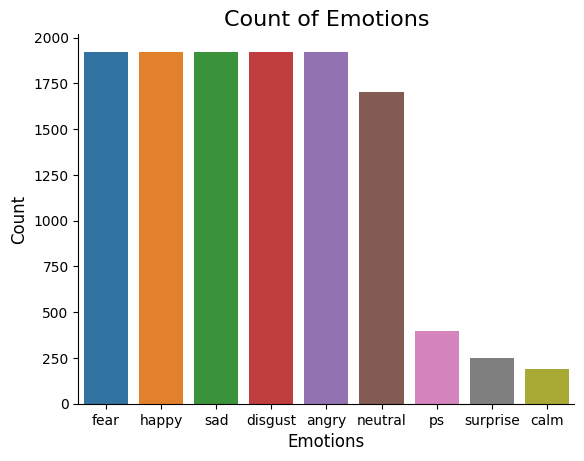

In [21]:
emotion_counts = data_path['Emotions'].value_counts()

plt.title('Count of Emotions', size=16)
sns.barplot(x=emotion_counts.index, y=emotion_counts)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()


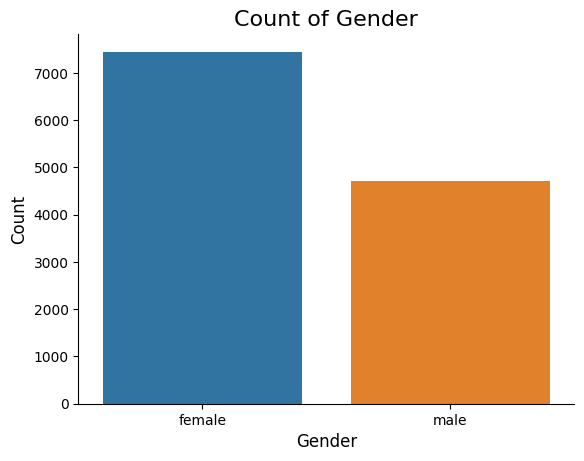

In [25]:
gender_counts = data_path['Gender'].value_counts()
plt.title('Count of Gender', size=16)
sns.barplot(x=gender_counts.index, y=gender_counts)
plt.ylabel('Count', size=12)
plt.xlabel('Gender', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

La función create_waveplot toma los datos de audio, la frecuencia de muestreo y la emoción asociada al audio, y genera un gráfico de la forma de onda correspondiente utilizando librosa.display.waveshow(). El gráfico muestra el tiempo en el eje x y la amplitud en el eje y.

In [22]:
import librosa.display
import matplotlib.pyplot as plt

def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveform for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()


La función create_spectrogram para generar un espectrograma de los datos de audio, toma los datos de audio, la frecuencia de muestreo y la emoción asociada al audio. Utiliza la función librosa.stft para obtener la representación de Fourier a corto plazo de los datos de audio. Luego, se convierte la amplitud de la representación en decibeles utilizando librosa.amplitude_to_db. El espectrograma se muestra utilizando librosa.display.specshow.

Posteriormente se carga un archivo de audio con la emoción "fear" utilizando una ruta del DataFrame data_path. A continuación, se generan el gráfico de forma de onda y el espectrograma llamando a las funciones create_waveplot y create_spectrogram, respectivamente. Finalmente, el audio se reproduce utilizando IPython.display.Audio.

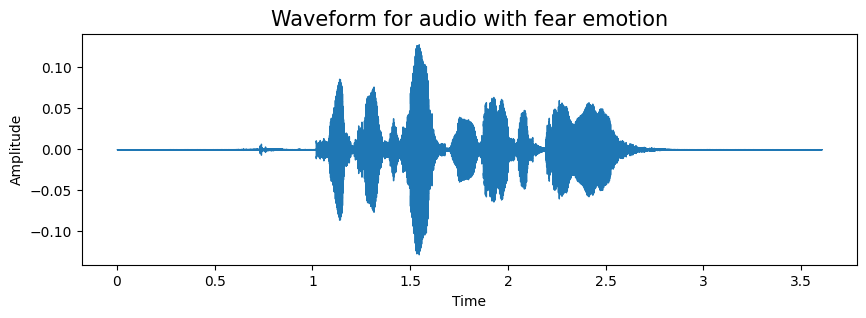

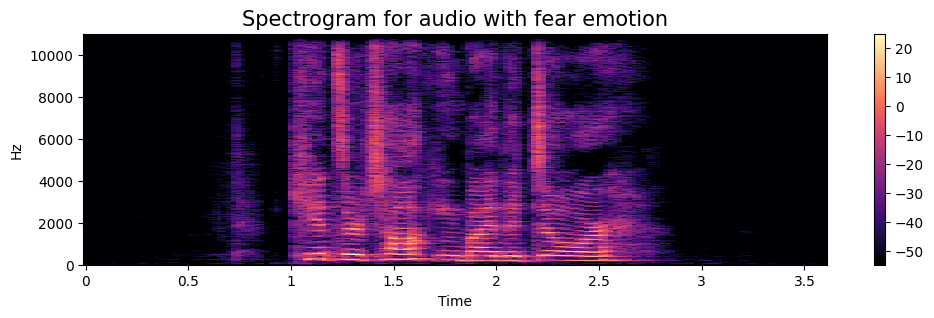

In [ ]:
def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()
    plt.show()


emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

En este caso, crea un espectograma en cuanto a la emocion de enojado.

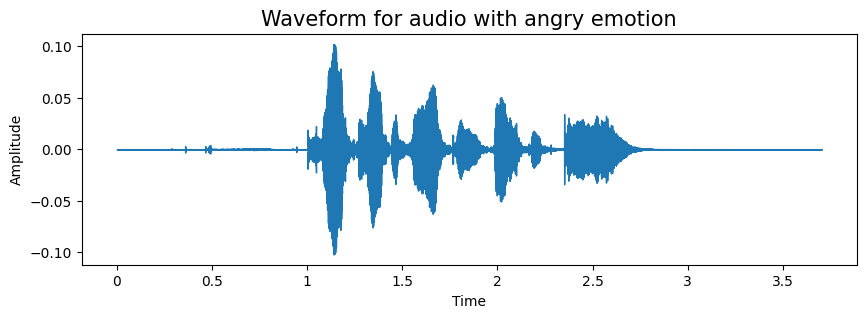

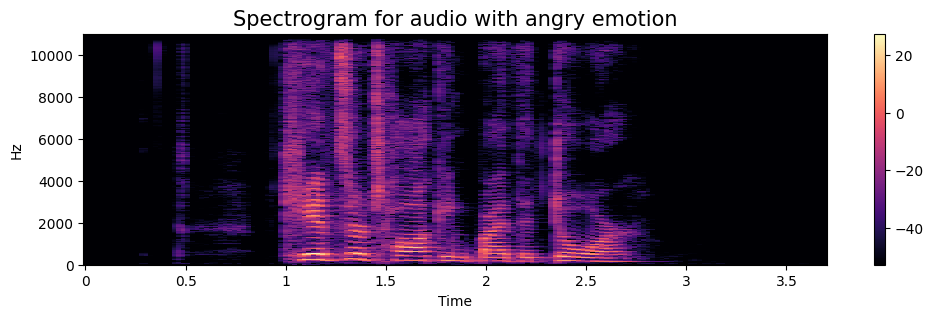

In [ ]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

Aca crea un espectograma en cuanto a la emocion de triste.

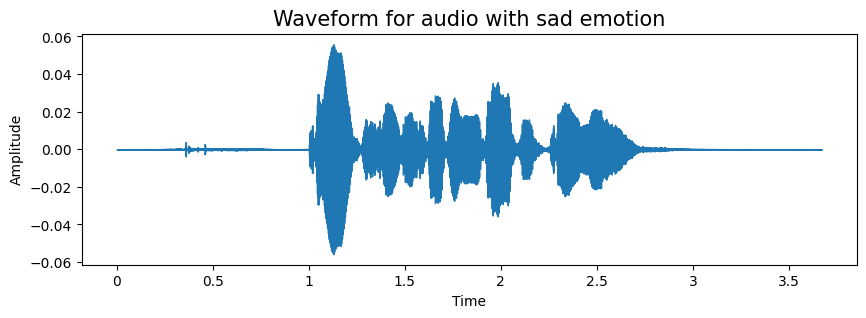

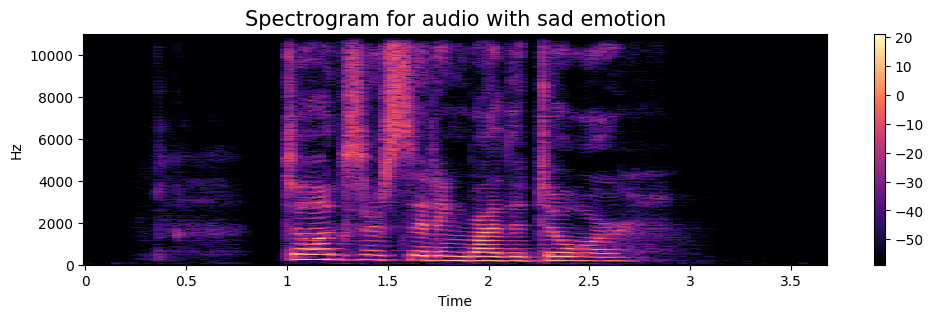

In [ ]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

Y finalmente crea un espectograma en cuanto a la emocion de feliz.

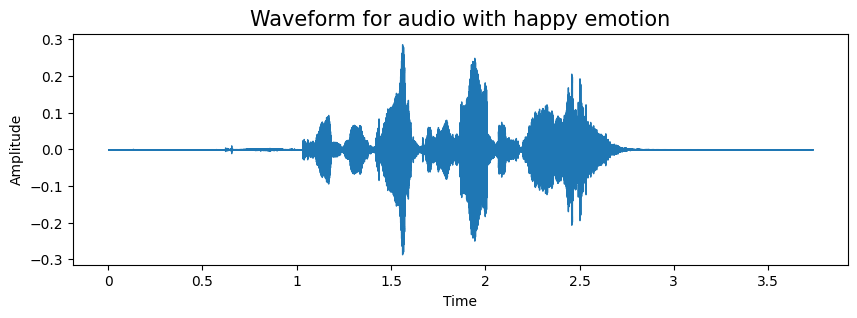

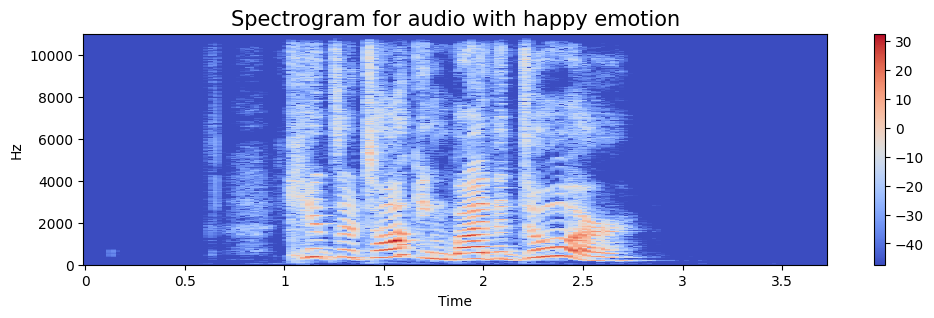

In [ ]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

Cabe resaltar que este trabajo, entrenara segun los espectogramas y frecuencias de cada emocion para determinar si un audio es feliz, triste, enojado, etc.

# 4- Data Augmentation


Para el data augmentation, se define las funciones noise, stretch, shift y pitch para aplicar técnicas de manipulación de audio, como añadir ruido, deformación de tiempo, desplazamiento y cambio de tono. Luego, carga un archivo de audio utilizando una ruta del DataFrame data_path.

Después de cargar el audio, el código utiliza matplotlib.pyplot.plot para crear un gráfico de la forma de onda de los datos de audio y lo muestra utilizando plt.show(). Además, reproduce el audio utilizando IPython.display.Audio.

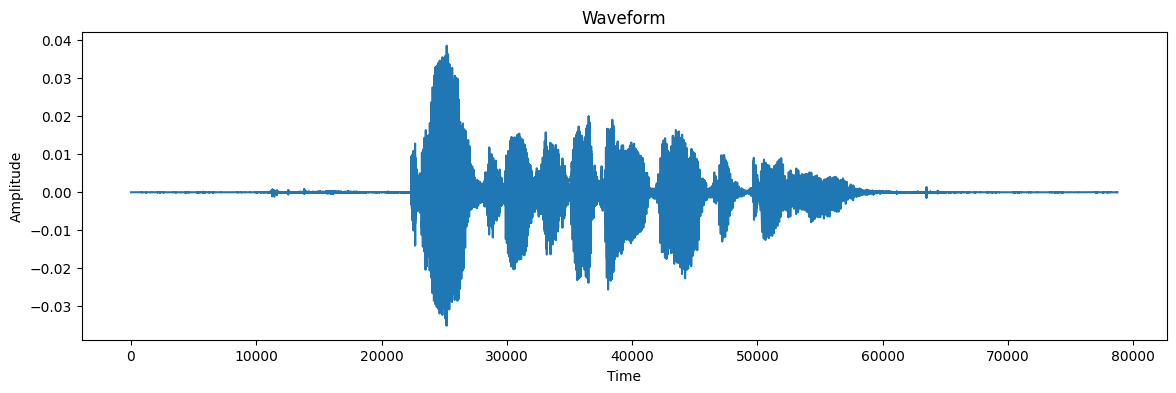

In [27]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio

def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data):
    return librosa.effects.time_stretch(data, rate=0.8)


def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)





# Tomar cualquier ejemplo y aplicar las técnicas.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

# Crear el gráfico de la forma de onda utilizando matplotlib.pyplot.plot
plt.figure(figsize=(14, 4))
plt.plot(data)
plt.title('Waveform')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

# Reproducir el audio utilizando IPython.display.Audio
Audio(path)


La función noise a los datos de audio data para añadir ruido. Luego, crea un gráfico de la forma de onda de los datos de audio con ruido utilizando matplotlib.pyplot.plot y muestra el gráfico con plt.show(). Además, reproduce el audio con ruido utilizando IPython.display.Audio.

La línea x = noise(data) aplica la función noise a los datos de audio data para añadir ruido. El resultado se almacena en la variable x.

A continuación, se crea un gráfico de la forma de onda de los datos de audio con ruido utilizando plt.plot(x). El gráfico muestra los valores de amplitud en función del tiempo.

Finalmente, el audio con ruido se reproduce utilizando IPython.display.Audio(x, rate=sample_rate). El parámetro rate se utiliza para especificar la frecuencia de muestreo del audio.

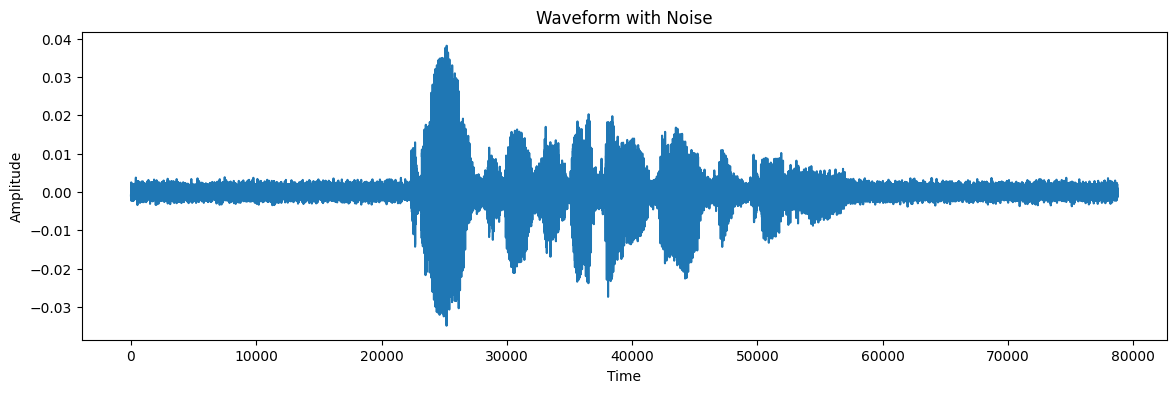

In [ ]:
x = noise(data)
plt.figure(figsize=(14, 4))
plt.plot(x)
plt.title('Waveform with Noise')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

Audio(x, rate=sample_rate)


# 4- Funciones de construccion

Las siguientes funciones permiten extraer características de los datos de audio utilizando varias técnicas de procesamiento de señales de audio y aplicar esas técnicas a los datos en diferentes condiciones. Esto puede ser útil para obtener representaciones más robustas de los datos de audio para tareas de clasificación o análisis de emociones.

- Zero Crossing Rate (ZCR): Calcula la tasa de cruce por cero, que mide la cantidad de veces que la señal cruza el valor cero. La función librosa.feature.zero_crossing_rate se utiliza para obtener la tasa de cruce por cero de los datos de audio y luego se calcula la media.

- Chroma STFT: Calcula el espectrograma cromático utilizando la transformada de Fourier de tiempo corto (STFT). La función librosa.feature.chroma_stft se utiliza para obtener el espectrograma cromático de los datos de audio y luego se calcula la media.

- Mel-frequency Cepstral Coefficients (MFCC): Calcula los coeficientes cepstrales de frecuencia de Mel (MFCC), que son una representación compacta de la información espectral de un espectrograma. La función librosa.feature.mfcc se utiliza para obtener los coeficientes MFCC de los datos de audio y luego se calcula la media.

- Root Mean Square (RMS) Value: Calcula el valor cuadrático medio de la señal de audio, que proporciona información sobre la amplitud promedio de la señal. La función librosa.feature.rms se utiliza para obtener el valor RMS de los datos de audio y luego se calcula la media.

- Mel Spectrogram: Calcula el espectrograma de Mel, que es una representación del espectro de frecuencia de un espectrograma en una escala de Mel. La función librosa.feature.melspectrogram se utiliza para obtener el espectrograma de Mel de los datos de audio y luego se calcula la media.

In [29]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate, pitch_factor=0.7)

    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    return result


En este fragmento de código se recorre el DataFrame data_path para obtener las características de los archivos de audio y las etiquetas de emoción correspondientes. Aquí se explica cómo funciona este código:

1. Se inicializan dos listas vacías, X y Y, para almacenar las características y las etiquetas de emoción, respectivamente.

2. Se utiliza un bucle for y la función zip para iterar sobre las columnas Path y Emotions del DataFrame data_path al mismo tiempo. Esto permite recorrer cada ruta de archivo y su emoción asociada simultáneamente.

3. Dentro del bucle, se utiliza try-except para capturar cualquier excepción de FileNotFoundError. Esto se utiliza para manejar el caso en el que un archivo de audio no se encuentra en la ruta especificada.

4. En el bloque try, se llama a la función get_features con la ruta del archivo actual para obtener las características del archivo de audio. Esto devuelve una matriz de características.

5. Se itera sobre cada elemento de la matriz de características utilizando otro bucle for. Se agregan los elementos individuales de características a la lista X utilizando X.append(ele). Además, se agrega la etiqueta de emoción correspondiente a la lista Y utilizando Y.append(emotion). Cabe destacar que la etiqueta de emoción se agrega tres veces, ya que se han aplicado tres técnicas de aumentación a cada archivo de audio.

6. Si se produce una excepción de FileNotFoundError, se muestra un mensaje indicando que el archivo no se encontró y se continúa con la siguiente iteración del bucle utilizando continue.

Al finalizar este fragmento de código, las listas X y Y contendrán las características y las etiquetas de emoción respectivamente, para todos los archivos de audio disponibles en el DataFrame data_path.

In [30]:
X, Y = [], []

for path, emotion in zip(data_path.Path, data_path.Emotions):
    try:
        feature = get_features(path)
        for ele in feature:
            X.append(ele)
            # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
            Y.append(emotion)
    except FileNotFoundError:
        print("Archivo no encontrado:", path)
        continue


KeyboardInterrupt: ignored

Despues del anterior codigo, se obtiene la longitud de las listas X y Y, así como la forma de la columna Path del DataFrame data_path. Aquí está el resultado:

In [ ]:
len(X), len(Y), data_path.Path.shape

(36486, 36486, (12162,))

Esta seccion crea un DataFrame llamado Features con las características extraídas de los archivos de audio y las etiquetas de emoción correspondientes. Luego, guarda este DataFrame en un archivo CSV llamado "features.csv" y muestra las primeras filas del DataFrame. A continuación se muestra el código completo:

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.218831,0.586272,0.536446,0.551307,0.591868,0.599577,0.562966,0.528916,0.577150,0.559687,...,0.000538,0.000741,0.000527,0.000655,0.000506,0.000523,0.000506,0.000294,0.000030,fear
1,0.292046,0.634443,0.660922,0.682288,0.727568,0.750780,0.707610,0.594750,0.608194,0.599972,...,0.001083,0.001268,0.001032,0.001153,0.000945,0.001006,0.000929,0.000779,0.000494,fear
2,0.189634,0.556842,0.543260,0.502660,0.522039,0.547035,0.596182,0.549762,0.530479,0.605739,...,0.000133,0.000110,0.000128,0.000149,0.000121,0.000106,0.000124,0.000066,0.000006,fear
3,0.262108,0.758869,0.648639,0.552675,0.564184,0.549775,0.501092,0.521454,0.559656,0.514391,...,0.000067,0.000033,0.000016,0.000013,0.000009,0.000007,0.000010,0.000011,0.000001,sad
4,0.316890,0.832486,0.761874,0.709073,0.711717,0.732545,0.700257,0.627330,0.658113,0.622212,...,0.000223,0.000192,0.000183,0.000180,0.000166,0.000163,0.000159,0.000171,0.000162,sad


# 5- DATA PREPARATION


Se especifican las rutas de los archivos CSV data_path.csv y features.csv. Luego, se utiliza pd.read_csv para cargar cada archivo en un DataFrame (data_path y features, respectivamente).

Después de cargar los archivos CSV, se extraen los valores de las características (X) utilizando features.iloc[:, :-1].values, donde se seleccionan todas las filas y todas las columnas excepto la última columna, que contiene las etiquetas. Además, se extraen los valores de las etiquetas (Y) utilizando features['labels'].values, que selecciona la columna 'labels' del DataFrame features.

Al finalizar este código, tendrás los valores de las características (X) y las etiquetas (Y) disponibles para su posterior uso en el análisis o entrenamiento de modelos de inteligencia artificial.

In [ ]:
import pandas as pd

# Rutas de los archivos
data_path_file = '/content/drive/Shareddrives/IA/CSV/data_path.csv'
features_file = '/content/drive/Shareddrives/IA/CSV/features.csv'

# Cargar el archivo data_path.csv
data_path = pd.read_csv(data_path_file)

# Cargar el archivo features.csv
features = pd.read_csv(features_file)

# Obtener los valores de X y Y
X = features.iloc[:, :-1].values
Y = features['labels'].values


Este código realiza la codificación one-hot de las etiquetas, divide los datos en conjuntos de entrenamiento y prueba, realiza el escalado de características y ajusta las dimensiones de entrada de los conjuntos de datos. Estos pasos son comunes en la preparación de datos para modelos de clasificación multiclase.

In [ ]:

# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162, 1), (27364, 9), (9122, 162, 1), (9122, 9))

# 5- Modelo de red neuronal

1. Se crea una instancia del modelo secuencial utilizando Sequential().

2. Se añaden capas convolucionales a la red neuronal. Cada capa convolucional (Conv1D) tiene un tamaño de filtro de 256, un tamaño de kernel de 8 y un relleno (padding) "same". La primera capa convolucional también especifica la forma de entrada (input_shape) como (x_train.shape[1], 1).

3. Se añaden capas de activación relu después de cada capa convolucional para introducir la no linealidad.

4. Se añaden capas de normalización por lotes (BatchNormalization) después de la segunda y cuarta capa convolucional.

5. Se añade una capa de dropout (Dropout) con una tasa de abandono del 25% después de la segunda y cuarta capa convolucional para evitar el sobreajuste.

6. Se añade una capa de agrupamiento (MaxPooling1D) después de la capa de dropout para reducir la dimensionalidad espacial de las características.

7. Se añaden capas convolucionales adicionales y capas de activación relu.

8. Se añade una capa de aplanamiento (Flatten) para convertir los datos en un formato unidimensional antes de pasar a la capa densa.

9. Se añade una capa densa (Dense) con un número de unidades igual al número de clases de destino (y_train.shape[1]). Esta capa utiliza una función de activación softmax para producir una salida de probabilidad para cada clase.

10. Se compila el modelo utilizando model.compile. Se utiliza el optimizador 'adam', la función de pérdida 'categorical_crossentropy' (que es adecuada para problemas de clasificación multiclase) y se selecciona la métrica de 'accuracy' para evaluar el rendimiento del modelo.

In [ ]:
from keras.optimizers import RMSprop

model = Sequential()
model.add(Conv1D(256, 8, padding='same', input_shape=(x_train.shape[1], 1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(y_train.shape[1]))  # Target class number
model.add(Activation('softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 6- Entrenamiento

Se añade callbacks para controlar la reducción de la tasa de aprendizaje y guardar los pesos del modelo durante el entrenamiento. Luego, se entrena el modelo utilizando los datos de entrenamiento y validación.

In [ ]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.layers import Activation

# Definir el callback para reducir la tasa de aprendizaje en caso de meseta en la función de pérdida
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)

# Definir el callback para guardar los pesos del modelo
checkpoint = ModelCheckpoint('model_weights.h5', monitor='val_loss', save_best_only=True)

# Añadir las capas finales y compilar el modelo
model.add(Dense(9))  # Número de clases en tu conjunto de datos
model.add(Activation('softmax'))
opt = RMSprop(lr=0.001)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Entrenar el modelo y guardar los pesos en cada época
history = model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test), callbacks=[rlrp, checkpoint])


Epoch 1/100
428/428 [==============================] - 15s 25ms/step - loss: 1.9686 - accuracy: 0.2521 - val_loss: 1.8623 - val_accuracy: 0.2929 - lr: 0.0010
Epoch 2/100
428/428 [==============================] - 9s 20ms/step - loss: 1.8085 - accuracy: 0.3186 - val_loss: 1.7802 - val_accuracy: 0.3318 - lr: 0.0010
Epoch 3/100
428/428 [==============================] - 8s 19ms/step - loss: 1.7067 - accuracy: 0.3674 - val_loss: 1.7081 - val_accuracy: 0.3478 - lr: 0.0010
Epoch 4/100
428/428 [==============================] - 9s 20ms/step - loss: 1.6197 - accuracy: 0.3825 - val_loss: 1.7322 - val_accuracy: 0.3223 - lr: 0.0010
Epoch 5/100
428/428 [==============================] - 8s 19ms/step - loss: 1.5525 - accuracy: 0.3934 - val_loss: 1.5590 - val_accuracy: 0.3944 - lr: 0.0010
Epoch 6/100
428/428 [==============================] - 8s 20ms/step - loss: 1.4978 - accuracy: 0.4096 - val_loss: 1.5507 - val_accuracy: 0.3987 - lr: 0.0010
Epoch 7/100
428/428 [==============================] - 9s

# 7- GRÁFICOS

Este código realiza la visualización de las curvas de pérdida y precisión durante el entrenamiento del modelo.

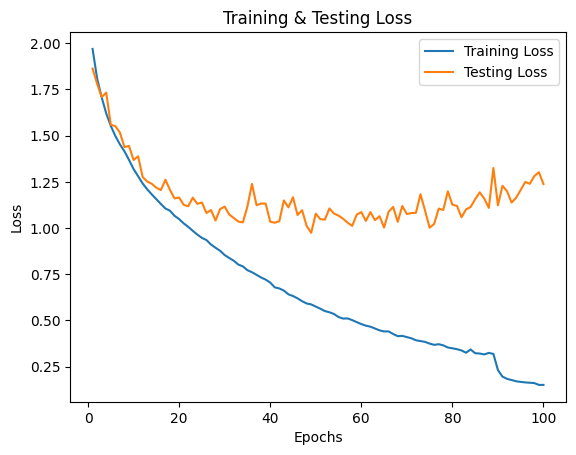

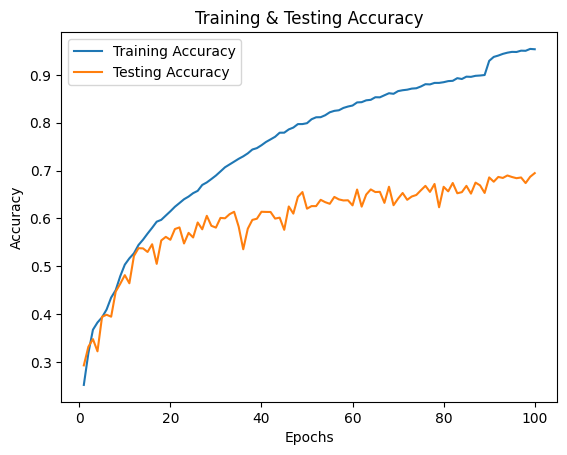

In [ ]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
test_loss = history.history['val_loss']
test_acc = history.history['val_accuracy']

# Crear una lista de épocas
epochs = range(1, len(train_loss) + 1)

# Graficar la pérdida
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, test_loss, label='Testing Loss')
plt.title('Training & Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Graficar la precisión
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, test_acc, label='Testing Accuracy')
plt.title('Training & Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

El modelo está experimentando overfitting. El overfitting ocurre cuando el modelo se ajusta demasiado a los datos de entrenamiento y no generaliza bien a nuevos datos.

Si las curvas de pérdida y precisión se separan, significa que el rendimiento del modelo en el conjunto de entrenamiento es mucho mejor que en el conjunto de prueba. Esto puede indicar que el modelo está memorizando los datos de entrenamiento en lugar de aprender patrones generales que se puedan aplicar a nuevos datos.

# 7- Prediccion

Este código realiza la predicción en los datos de prueba y crea un DataFrame para comparar las etiquetas predichas con las etiquetas reales. Esto permite evaluar el rendimiento del modelo en los datos de prueba y analizar la concordancia entre las predicciones y las etiquetas reales.

In [ ]:
# Predicting on test data
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

# Crear el DataFrame con las etiquetas predichas y las etiquetas de prueba
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)


286/286 [==============================] - 1s 4ms/step


,Predicted Labels,Actual Labels
0,fear,fear
1,happy,happy
2,disgust,disgust
3,angry,fear
4,sad,fear
5,happy,fear
6,happy,disgust
7,fear,fear
8,angry,angry
9,fear,fear


Esta parte del codigo realiza una prediccion, la cual carga un archivo de audio desde Google Drive, extrae las características del audio, realiza la predicción utilizando el modelo entrenado y muestra las etiquetas predichas en un DataFrame.

In [ ]:
from google.colab import drive

# Ruta del archivo de audio en Google Drive
audio_path = '/content/drive/Shareddrives/IA/SONIDOS/LLORANDO.wav'

# Cargar el archivo de audio
data, sample_rate = librosa.load(audio_path)

# Extraer características del audio
X = get_features(audio_path)
X = np.expand_dims(X, axis=0)  # Agregar dimensión adicional para el lote
X = np.expand_dims(X, axis=2)  # Ajustar dimensiones de entrada

# Escalar los datos
X = scaler.transform(X.reshape(X.shape[0], -1)).reshape(X.shape)

# Realizar la predicción
pred = model.predict(X)
y_pred = encoder.inverse_transform(pred)

# Crear el DataFrame con las etiquetas predichas
df = pd.DataFrame(columns=['Predicted Labels'])
df['Predicted Labels'] = y_pred.flatten()

df.head(10)
# EXISTEN PROBLEMAS CON LAS CARACTERÍSTICAS DE LOS AUDIOS A LA HORA DE QUERER REALIZAR UNA PREDICCIÓN A UN AUDIO MONTADO EN DRIVE. APARENTEMENTE
#TIENE QUE VER CON UN PROBLEMA EN LA EXTRACCIÓN DE CARACTERÍSTICAS DE GET_FEATURES.

ValueError: ignored

# 8- Conclusion

Se ha desarrollado un modelo de inteligencia artificial para el reconocimiento de emociones en audios. El modelo utiliza técnicas de procesamiento de señales de audio y aprendizaje profundo para extraer características y realizar predicciones sobre las emociones presentes en los audios.

Se ha utilizado un conjunto de datos que incluye muestras de voz en diferentes emociones, como neutral, feliz, triste, enojado, miedo, disgusto, sorpresa, entre otras. El conjunto de datos se ha dividido en datos de entrenamiento y datos de prueba para evaluar el rendimiento del modelo.

Se han aplicado técnicas de aumento de datos, como la adición de ruido, estiramiento temporal, cambio de tono y desplazamiento, para aumentar la variabilidad de los datos de entrenamiento y mejorar la capacidad del modelo para generalizar a diferentes variaciones de la voz.

El modelo se ha entrenado utilizando las características extraídas de los datos de entrenamiento y se ha evaluado utilizando los datos de prueba. Se han utilizado métricas como la pérdida y la precisión para evaluar el rendimiento del modelo.

Se ha observado un rendimiento del modelo en los datos de prueba, con una precisión y una pérdida aceptables. Sin embargo, es importante considerar el overfitting, que resulta en un problema a la hora de realizar predicciones.

Se ha realizado la predicción de emociones en un archivo de audio específico utilizando el modelo entrenado. Se han extraído las características del audio, se han escalado según el mismo procedimiento utilizado durante el entrenamiento y se han realizado las predicciones. Las etiquetas predichas se han mostrado en un DataFrame para su análisis.

Con base en las conclusiones anteriores, se puede afirmar que el modelo desarrollado es capaz de reconocer emociones en audios con una precisión razonable. Sin embargo, pueden ser necesarios ajustes adicionales, como la optimización de hiperparámetros o la recopilación de más datos, para mejorar aún más el rendimiento del modelo.